In [1]:
#!/usr/bin/env python
# coding: utf-8

import os
import json
import numpy as np
import pandas as pd
from collections import Counter

pd.set_option("display.max_columns", 250)
pd.set_option("display.width", 220)


# =============================
# PATHS
# =============================
LABEL_DIR = "../labels_k2"
DATASET_DIR = "../create_datasets"

TEAM_MATCH_LABEL_PATHS = {
    "ip": os.path.join(LABEL_DIR, "ip_team_match_labels.csv"),
    "op": os.path.join(LABEL_DIR, "op_team_match_labels.csv"),
    "pt": os.path.join(LABEL_DIR, "pt_team_match_labels.csv"),
    "nt": os.path.join(LABEL_DIR, "nt_team_match_labels.csv"),
}

TEAM_MAJORITY_LABEL_PATHS = {
    "ip": os.path.join(LABEL_DIR, "ip_team_labels_majority.csv"),
    "op": os.path.join(LABEL_DIR, "op_team_labels_majority.csv"),
    "pt": os.path.join(LABEL_DIR, "pt_team_labels_majority.csv"),
    "nt": os.path.join(LABEL_DIR, "nt_team_labels_majority.csv"),
}

FEATURE_CSV_PATHS = {
    "ip": os.path.join(DATASET_DIR, "final_final_possesion_df.csv"),
    "op": os.path.join(DATASET_DIR, "final_out_of_possesion_df.csv"),
    "pt": os.path.join(DATASET_DIR, "final_transition_in_poss_df.csv"),
    "nt": os.path.join(DATASET_DIR, "final_transition_out_of_poss_df.csv"),
}

MATCH_PATHS = [
    "../matches/matches_England.json",
    "../matches/matches_France.json",
    "../matches/matches_Germany.json",
    "../matches/matches_Italy.json",
    "../matches/matches_Spain.json",
]
TEAMS_PATH = "../events/teams.json"


# =============================
# CLUSTER NAMING PLACEHOLDER 
# IMPORTANT: separate naming per phase (labels do NOT match across phases)
# =============================
CLUSTER_NAMES = {
    "ip": {
        0: "IP Cluster 0 (PLACEHOLDER)",
        1: "IP Cluster 1 (PLACEHOLDER)",


    },
    "pt": {
        0: "PT Cluster 0 (PLACEHOLDER)",
        1: "PT Cluster 1 (PLACEHOLDER)",

    },
    "op": {
        0: "OP Cluster 0 (PLACEHOLDER)",
        1: "OP Cluster 1 (PLACEHOLDER)",

    },
    "nt": {
        0: "NT Cluster 0 (PLACEHOLDER)",
        1: "NT Cluster 1 (PLACEHOLDER)",

    },
}


def label_to_name(phase: str, label: int) -> str:
    d = CLUSTER_NAMES.get(phase, {})
    return d.get(int(label), f"{phase.upper()} Cluster {int(label)}")

# =============================
# LOAD BASE DATA
# =============================
def load_matches_and_teams():
    all_matches = []
    for p in MATCH_PATHS:
        with open(p, "r") as f:
            all_matches.extend(json.load(f))
    all_matches_df = pd.DataFrame(all_matches)

    with open(TEAMS_PATH, "r") as f:
        teams_data = json.load(f)
    teams_df = pd.DataFrame(teams_data)[["wyId", "name"]].rename(columns={"wyId": "teamId"})

    return all_matches_df, teams_df


all_matches_df, teams_df = load_matches_and_teams()
print("Matches:", all_matches_df.shape, "| Teams:", teams_df.shape)


# =============================
# HELPERS
# =============================
def load_team_majority(path, phase):
    """
    Loads team-level majority label file and returns: teamId + label_<phase>.
    Expects 'max_label' in file.
    """
    df = pd.read_csv(path)
    if "teamId" not in df.columns:
        raise ValueError(f"{path} missing teamId. Columns: {df.columns.tolist()}")
    if "max_label" not in df.columns:
        raise ValueError(f"{path} missing max_label. Columns: {df.columns.tolist()}")
    out = df[["teamId", "max_label"]].copy()
    out = out.rename(columns={"max_label": f"label_{phase}"})
    return out


def phase_pair_crosstab(team_level_df, a_col, b_col):
    """
    Row-normalized crosstab: for each label in A, distribution of labels in B.
    """
    return pd.crosstab(team_level_df[a_col], team_level_df[b_col], normalize="index")


from collections import Counter
import plotly.graph_objects as go
import pandas as pd

def sankey_two_phase_with_percentages(
    team_level_df,
    src_col,
    tgt_col,
    src_phase="SRC",
    tgt_phase="TGT"
):
    src = team_level_df[src_col].astype(int).tolist()
    tgt = team_level_df[tgt_col].astype(int).tolist()

    flows = Counter(zip(src, tgt))

    # Total outgoing flow per source (for row-normalized %)
    src_totals = Counter(src)

    sources, targets, values, labels = [], [], [], []

    for (s, t), v in flows.items():
        pct = v / src_totals[s] * 100
        sources.append(s)
        targets.append(4 + t)
        values.append(v)
        labels.append(f"{pct:.1f}%")

    node_labels = (
        [label_to_name(src_phase, i) for i in range(4)] +
        [label_to_name(tgt_phase, i) for i in range(4)]
    )

    fig = go.Figure(data=[go.Sankey(
        node=dict(
            label=node_labels,
            pad=15,
            thickness=20
        ),
        link=dict(
            source=sources,
            target=targets,
            value=values,
            label=labels   # <-- percentages printed on pipes
        )
    )])

    fig.update_layout(
        title_text=f"Sankey: {src_phase.upper()} → {tgt_phase.upper()}",
        font_size=12
    )

    return fig


def compute_match_result(df):
    """
    winner: 0 draw, else teamId that won.
    """
    df = df.copy()
    df["Match_Result"] = np.where(
        df["winner"] == 0, "Draw",
        np.where(df["winner"] == df["teamId"], "Win", "Lose")
    )
    return df


def get_opponent_team_id(row):
    teams = list(row["teamsData"].keys()) if isinstance(row["teamsData"], dict) else list(row["teamsData"])
    teams_int = [int(t) for t in teams]
    for t in teams_int:
        if t != int(row["teamId"]):
            return t
    return np.nan


def add_opponent_cluster(df_team_match, label_col="dec_label"):
    """
    Adds opponent cluster inside the SAME PHASE label space:
      Opponent_Cluster := label of opponent team in the SAME match and phase.
    """
    df = df_team_match.copy()
    df["teamId"] = df["teamId"]
    df["matchId"] = df["matchId"]
    df[label_col] = df[label_col]

    key = list(zip(df["teamId"], df["matchId"]))
    team_match_to_cluster = dict(zip(key, df[label_col]))

    df["Opponent_teamId"] = df.apply(get_opponent_team_id, axis=1).astype("Int64")

    def lookup_opp_cluster(r):
        if pd.isna(r["Opponent_teamId"]):
            return np.nan
        return team_match_to_cluster.get((int(r["Opponent_teamId"]), int(r["matchId"])), np.nan)

    df["Opponent_Cluster"] = df.apply(lookup_opp_cluster, axis=1)
    return df


def outcome_percentages(df, cluster_col="dec_label"):
    counts = df.groupby([cluster_col, "Match_Result"]).size().unstack(fill_value=0)
    pct = counts.div(counts.sum(axis=1), axis=0) * 100
    return pct


# =============================
# 1) FEATURE MEANS PER CLUSTER (PER PHASE)
# Reads create_datasets CSVs + merges with team-match labels on uniqueTeamId
# =============================
def load_features_for_phase(phase: str) -> pd.DataFrame:
    feat = pd.read_csv(FEATURE_CSV_PATHS[phase])

    # Some of your datasets may have Unnamed: 0 as uniqueTeamId (PT commonly)
    if "uniqueTeamId" not in feat.columns and "Unnamed: 0" in feat.columns:
        feat = feat.rename(columns={"Unnamed: 0": "uniqueTeamId"})

    if "uniqueTeamId" not in feat.columns:
        raise ValueError(f"[{phase}] Could not find uniqueTeamId in features file. Columns: {feat.columns.tolist()}")

    return feat


def cluster_feature_means(phase: str) -> pd.DataFrame:
    labels = pd.read_csv(TEAM_MATCH_LABEL_PATHS[phase])

    if "uniqueTeamId" not in labels.columns or "dec_label" not in labels.columns:
        raise ValueError(f"[{phase}] labels file must have uniqueTeamId + dec_label.")

    feat = load_features_for_phase(phase)

    # Merge features + cluster labels per team-match
    merged = feat.merge(labels[["uniqueTeamId", "dec_label"]], on="uniqueTeamId", how="inner")

    # Feature columns = everything except ids + label
    ignore = {"uniqueTeamId", "teamId", "matchId", "phase", "k", "dec_label"}
    feature_cols = [c for c in merged.columns if c not in ignore and not c.startswith("q_") and not c.startswith("z_")]

    # Means by cluster
    means = merged.groupby("dec_label")[feature_cols].mean(numeric_only=True)

    # Add readable names
    means.insert(0, "cluster_name", [label_to_name(phase, idx) for idx in means.index])
    means = means.reset_index().rename(columns={"dec_label": "cluster_label"})

    return means


def print_cluster_feature_means(phase: str):
    means = cluster_feature_means(phase)
    print(f"\n===== {phase.upper()} cluster feature means (per feature) =====")
    # Full table (can be wide)
    display(means)
    return means


# =============================
# 2) CROSS-PHASE FLOWS (ONLY IP↔PT and OP↔NT)
# Uses TEAM-LEVEL majority labels.
# =============================
def build_team_level_pairs():
    ip = load_team_majority(TEAM_MAJORITY_LABEL_PATHS["ip"], "ip")
    pt = load_team_majority(TEAM_MAJORITY_LABEL_PATHS["pt"], "pt")
    op = load_team_majority(TEAM_MAJORITY_LABEL_PATHS["op"], "op")
    nt = load_team_majority(TEAM_MAJORITY_LABEL_PATHS["nt"], "nt")

    ip_pt = ip.merge(pt, on="teamId", how="inner")
    op_nt = op.merge(nt, on="teamId", how="inner")

    # Add readable names (phase-specific)
    ip_pt["ip_name"] = ip_pt["label_ip"].astype(int).apply(lambda x: label_to_name("ip", x))
    ip_pt["pt_name"] = ip_pt["label_pt"].astype(int).apply(lambda x: label_to_name("pt", x))

    op_nt["op_name"] = op_nt["label_op"].astype(int).apply(lambda x: label_to_name("op", x))
    op_nt["nt_name"] = op_nt["label_nt"].astype(int).apply(lambda x: label_to_name("nt", x))

    return ip_pt, op_nt



def print_flow_tables():
    ip_pt, op_nt = build_team_level_pairs()

    print("\n===== IP → PT flow (row-normalized) =====")
    ct_ip_pt = phase_pair_crosstab(ip_pt, "ip_name", "pt_name")
    display(ct_ip_pt)

    print("\n===== OP → NT flow (row-normalized) =====")
    ct_op_nt = phase_pair_crosstab(op_nt, "op_name", "nt_name")
    display(ct_op_nt)

    return ip_pt, op_nt, ct_ip_pt, ct_op_nt


# =============================
# 3) SUCCESS ANALYSIS (PER PHASE, label space is internal to each phase)
# =============================
def analyze_phase_success(phase: str):
    tm = pd.read_csv(TEAM_MATCH_LABEL_PATHS[phase])

    needed = {"matchId", "teamId", "dec_label"}
    missing = needed - set(tm.columns)
    if missing:
        raise ValueError(f"[{phase}] labels missing columns: {missing}")

    tm["matchId"] = tm["matchId"]
    tm["teamId"] = tm["teamId"]
    tm["dec_label"] = tm["dec_label"]

    m = tm.merge(
        all_matches_df[["wyId", "winner", "teamsData"]],
        left_on="matchId",
        right_on="wyId",
        how="inner"
    ).drop(columns=["wyId"])

    m = compute_match_result(m)
    m = add_opponent_cluster(m, label_col="dec_label")

    # Cluster -> W/D/L %
    pct = outcome_percentages(m, cluster_col="dec_label")
    pct.index = pct.index
    pct.insert(0, "cluster_name", [label_to_name(phase, idx) for idx in pct.index])

    # (Cluster, Opponent_Cluster) -> W/D/L % (normalized per pair)
    grouped = m.groupby(["dec_label", "Opponent_Cluster", "Match_Result"]).size().unstack(fill_value=0)
    matrix = grouped.div(grouped.sum(axis=1), axis=0) * 100

    return m, pct, matrix


def print_success_tables_for_phase(phase: str):
    m, pct, matrix = analyze_phase_success(phase)

    print(f"\n===== {phase.upper()} cluster success (Win/Draw/Lose %) =====")
    display(pct)

    # Win% grid (cluster vs opponent_cluster)
    if "Win" in matrix.columns:
        win_grid = matrix["Win"].unstack()
        print(f"\n===== {phase.upper()} Win% grid: cluster vs opponent_cluster =====")
        display(win_grid)
    else:
        win_grid = None

    return m, pct, matrix, win_grid

def overall_feature_importance_eta2(phase: str) -> pd.DataFrame:
    """
    Overall (global) feature importance for a phase using eta-squared:
      eta2 = between_cluster_variance / total_variance
    Higher => feature separates clusters better overall.
    Returns a dataframe: feature, eta2
    """
    labels = pd.read_csv(TEAM_MATCH_LABEL_PATHS[phase])
    feat = load_features_for_phase(phase)

    merged = feat.merge(labels[["uniqueTeamId", "dec_label"]], on="uniqueTeamId", how="inner")

    ignore = {"uniqueTeamId", "teamId", "matchId", "phase", "k", "dec_label"}
    feature_cols = [
        c for c in merged.columns
        if c not in ignore and not c.startswith("q_") and not c.startswith("z_")
    ]

    y = merged["dec_label"]

    overall_mean = merged[feature_cols].mean(numeric_only=True)
    total_var = merged[feature_cols].var(numeric_only=True, ddof=0).replace(0, np.nan)

    # between-cluster variance = sum_k p_k (mu_k - mu)^2
    grp = merged.groupby("dec_label")[feature_cols]
    mu_k = grp.mean(numeric_only=True)
    p_k = grp.size() / len(merged)

    between_var = ((mu_k - overall_mean) ** 2).mul(p_k, axis=0).sum(axis=0)

    eta2 = (between_var / total_var).fillna(0.0)

    out = (eta2.rename("eta2")
              .reset_index()
              .rename(columns={"index": "feature"})
              .sort_values("eta2", ascending=False)
              .reset_index(drop=True))

    return out


def cluster_means_on_top_features(phase: str, top_k: int = 15) -> pd.DataFrame:
    """
    Builds a compact table:
      - rows: clusters (with cluster_name)
      - cols: top_k overall-important features (by eta2)
      - values: cluster means
    Also includes overall mean row for reference.
    """
    # importance
    imp = overall_feature_importance_eta2(phase)
    top_features = imp["feature"].head(top_k).tolist()

    # merged dataset for cluster means
    labels = pd.read_csv(TEAM_MATCH_LABEL_PATHS[phase])
    feat = load_features_for_phase(phase)
    merged = feat.merge(labels[["uniqueTeamId", "dec_label"]], on="uniqueTeamId", how="inner")

    cluster_means = merged.groupby("dec_label")[top_features].mean(numeric_only=True)
    cluster_means.index = cluster_means.index

    # add cluster_name + reset
    out = cluster_means.copy()
    out.insert(0, "cluster_name", [label_to_name(phase, int(i)) for i in out.index])
    out = out.reset_index().rename(columns={"dec_label": "cluster_label"})

    # add overall mean row (optional but very useful)
    overall_row = pd.DataFrame([merged[top_features].mean(numeric_only=True)])
    overall_row.insert(0, "cluster_name", "OVERALL_MEAN")
    overall_row.insert(0, "cluster_label", -1)
    out = pd.concat([overall_row, out], ignore_index=True)

    return out, imp

def run_cluster_naming_workflow(phase: str, top_k: int = 15):
    means_table, imp = cluster_means_on_top_features(phase, top_k=top_k)

    print(f"\n===== {phase.upper()} OVERALL FEATURE IMPORTANCE (eta²) =====")
    display(imp.head(top_k))

    print(f"\n===== {phase.upper()} CLUSTER MEANS ON TOP-{top_k} IMPORTANT FEATURES =====")
    display(means_table)

    return means_table, imp



def add_named_cluster_columns(m, phase: str):
    """
    Adds readable cluster names for:
      - team's cluster
      - opponent's cluster
    """
    m = m.copy()
    m["Cluster_Name"] = m["dec_label"].apply(lambda x: label_to_name(phase, x))
    m["Opponent_Cluster_Name"] = m["Opponent_Cluster"].apply(
        lambda x: label_to_name(phase, int(x)) if pd.notna(x) else np.nan
    )
    return m


def win_percentages_named(pct_df, phase: str):
    """
    pct_df is the output of analyze_phase_success (pct).
    Ensures index/name alignment and returns a nice display df.
    """
    pct = pct_df.copy()
    # pct already has 'cluster_name' inserted in your function; keep it first
    cols = ["cluster_name"] + [c for c in pct.columns if c != "cluster_name"]
    return pct[cols]


def win_grid_named(matrix, phase: str):
    """
    matrix: MultiIndex rows (dec_label, Opponent_Cluster) with columns Win/Draw/Lose.
    Returns Win% grid with named rows/cols.
    """
    if "Win" not in matrix.columns:
        return None

    win_grid = matrix["Win"].unstack()  # rows=cluster, cols=opp_cluster

    # rename index/cols
    win_grid.index = [label_to_name(phase, int(i)) for i in win_grid.index]
    win_grid.columns = [label_to_name(phase, int(j)) for j in win_grid.columns]
    return win_grid


def consistency_and_transition_change(ip_pt: pd.DataFrame, op_nt: pd.DataFrame):
    """
    Identifies consistent vs changer teams for:
      - IP vs PT
      - OP vs NT
    Returns dataframes with team names.
    """
    # IP vs PT
    ip_pt = ip_pt.copy()
    ip_pt["is_consistent"] = (ip_pt["ip_name"] == ip_pt["pt_name"])
    ip_pt = ip_pt.merge(teams_df, on="teamId", how="left")

    consistent_ip_pt = ip_pt[ip_pt["is_consistent"]].copy()
    change_ip_pt = ip_pt[~ip_pt["is_consistent"]].copy()

    # OP vs NT
    op_nt = op_nt.copy()
    op_nt["is_consistent"] = (op_nt["op_name"] == op_nt["nt_name"])
    op_nt = op_nt.merge(teams_df, on="teamId", how="left")

    consistent_op_nt = op_nt[op_nt["is_consistent"]].copy()
    change_op_nt = op_nt[~op_nt["is_consistent"]].copy()


    # sort for readability
    consistent_ip_pt = consistent_ip_pt.sort_values(["ip_name", "name"])
    change_ip_pt = change_ip_pt.sort_values(["ip_name", "pt_name", "name"])
    consistent_op_nt = consistent_op_nt.sort_values(["op_name", "name"])
    change_op_nt = change_op_nt.sort_values(["op_name", "nt_name", "name"])

    return {
        "consistent_ip_pt": consistent_ip_pt[["teamId", "name", "ip_name", "pt_name"]],
        "change_ip_pt": change_ip_pt[["teamId", "name", "ip_name", "pt_name"]],
        "consistent_op_nt": consistent_op_nt[["teamId", "name", "op_name", "nt_name"]],
        "change_op_nt": change_op_nt[["teamId", "name", "op_name", "nt_name"]],
    }


Matches: (1826, 14) | Teams: (142, 2)


In [2]:
# ==========================================================
# A) CLUSTER INTERPRETATION WORKFLOW
# ==========================================================
for phase in ["ip", "pt", "op", "nt"]:
    run_cluster_naming_workflow(phase, top_k=50)


===== IP OVERALL FEATURE IMPORTANCE (eta²) =====


,feature,eta2
0,High_pass_Ratio_Total,0.545186
1,Low_pass_Ratio_Total,0.539566
2,Total_Passes,0.474918
3,Low_pass_Ratio_Zone1,0.472221
4,High_pass_Ratio_Zone1,0.470757
5,Forward Pass Ratio,0.449111
6,Forward Pass_Zone_1 Ratio,0.411308
7,Side Pass Ratio,0.410686
8,Low_pass_Ratio_Zone2,0.351647
9,High_pass_Ratio_Zone2,0.330327



===== IP CLUSTER MEANS ON TOP-50 IMPORTANT FEATURES =====


,cluster_label,cluster_name,High_pass_Ratio_Total,Low_pass_Ratio_Total,Total_Passes,Low_pass_Ratio_Zone1,High_pass_Ratio_Zone1,Forward Pass Ratio,Forward Pass_Zone_1 Ratio,Side Pass Ratio,Low_pass_Ratio_Zone2,High_pass_Ratio_Zone2,Side Pass_Zone_2 Ratio,Connectivity,High_pass_Ratio_Zone3,Low_pass_Ratio_Zone3,Backward Pass_Zone_1 Ratio,Total Shots,ABCA,ABCB,ABCD,Forward Pass_Zone_2 Ratio,Backward Pass_Zone_3 Ratio,Side Pass_Zone_3 Ratio,Middle Distance Shots Ratio,ABAB,Far Shots Ratio,Forward Pass_Zone_3 Ratio,Backward Pass_Zone_2 Ratio,Near Shots Ratio,Side Pass_Zone_1 Ratio,Backward Pass Ratio
0,-1,OVERALL_MEAN,0.154642,0.827012,428.629792,0.794748,0.203706,0.354428,0.142671,0.500512,0.886817,0.097842,0.233004,7.452148,0.203945,0.746646,0.023781,11.088243,0.092979,0.093592,0.778740,0.162854,0.046520,0.127328,0.443907,0.034688,0.291783,0.048904,0.074759,0.264311,0.140180,0.145060
1,0,IP Cluster 0 (PLACEHOLDER),0.117678,0.864303,515.928767,0.854934,0.143734,0.321360,0.113250,0.533764,0.912374,0.074491,0.261418,7.898842,0.178980,0.771532,0.020490,12.466301,0.096939,0.097486,0.771840,0.158565,0.049122,0.132505,0.460258,0.033734,0.279486,0.049546,0.075262,0.260256,0.139841,0.144875
2,1,IP Cluster 1 (PLACEHOLDER),0.191566,0.789761,341.426382,0.734627,0.263613,0.387460,0.172059,0.467296,0.861287,0.121166,0.204620,7.005943,0.228882,0.721787,0.027068,9.709430,0.089023,0.089702,0.785633,0.167138,0.043920,0.122156,0.427547,0.035642,0.304086,0.048263,0.074256,0.268368,0.140519,0.145244



===== PT OVERALL FEATURE IMPORTANCE (eta²) =====


,feature,eta2
0,High_pass_Ratio_Total,0.205158
1,Forward Pass_Zone_1 Ratio,0.199439
2,Total_Passes,0.195416
3,Low_pass_Ratio_Total,0.188850
4,High_pass_Ratio_Zone2,0.185968
5,Low_pass_Ratio_Zone2,0.184106
6,Connectivity,0.161566
7,Side Pass_Zone_2 Ratio,0.150890
8,Middle Ratio,0.125067
9,Forward Pass Ratio,0.101717



===== PT CLUSTER MEANS ON TOP-50 IMPORTANT FEATURES =====


,cluster_label,cluster_name,High_pass_Ratio_Total,Forward Pass_Zone_1 Ratio,Total_Passes,Low_pass_Ratio_Total,High_pass_Ratio_Zone2,Low_pass_Ratio_Zone2,Connectivity,Side Pass_Zone_2 Ratio,Middle Ratio,Forward Pass Ratio,Low_pass_Ratio_Zone1,High_pass_Ratio_Zone1,Backward Pass Ratio,Total Shots,Backward Pass_Zone_3 Ratio,Backward Pass_Zone_2 Ratio,Side Pass_Zone_1 Ratio,Long Ratio,Backward Pass_Zone_1 Ratio,ABCB,ABCD,Side Pass Ratio,ABCA,High_pass_Ratio_Zone3,Low_pass_Ratio_Zone3,average_pass_length,Far Shots Ratio,Forward Pass_Zone_2 Ratio,Middle Distance Shots Ratio Ratio,Forward Pass_Zone_3 Ratio,Short Ratio,Near Shots Ratio,Smart_pass_Ratio_Total,ABAB,Side Pass_Zone_3 Ratio
0,-1,OVERALL_MEAN,0.146302,0.172167,269.253286,0.837169,0.092689,0.891058,6.198744,0.216834,0.326979,0.371390,0.797445,0.200876,0.145322,4.928911,0.043694,0.072461,0.162403,0.343363,0.029167,0.082744,0.799845,0.483288,0.082218,0.167686,0.784856,24.574899,0.310724,0.159750,0.001643,0.039473,0.329657,0.26146,0.016529,0.035192,0.104051
1,0,PT Cluster 0 (PLACEHOLDER),0.124469,0.151868,291.829346,0.858563,0.075036,0.909834,6.570671,0.235531,0.341652,0.355281,0.823723,0.174804,0.152648,5.567669,0.049101,0.077242,0.151683,0.331289,0.026306,0.079777,0.805866,0.492071,0.079609,0.157088,0.794070,24.292369,0.286526,0.162683,0.001550,0.040730,0.327058,0.27222,0.016968,0.034748,0.104856
2,1,PT Cluster 1 (PLACEHOLDER),0.169491,0.193728,245.274986,0.814445,0.111438,0.871116,5.803715,0.196975,0.311395,0.388500,0.769535,0.228567,0.137541,4.233781,0.037952,0.067384,0.173789,0.356187,0.032205,0.085895,0.793451,0.473959,0.084990,0.178942,0.775070,24.874978,0.337058,0.156635,0.001744,0.038137,0.332418,0.24975,0.016064,0.035664,0.103195



===== OP OVERALL FEATURE IMPORTANCE (eta²) =====


,feature,eta2
0,Acceleration,0.317038
1,Forward Run,0.278978
2,Zone_2_Run,0.232307
3,Short Run,0.194560
4,Middle Run,0.156591
5,Long Run,0.153198
6,Zone_1_Run,0.143147
7,Zone_3_Run,0.129708
8,Side Run,0.116308
9,Ground attacking duel,0.095611



===== OP CLUSTER MEANS ON TOP-50 IMPORTANT FEATURES =====


,cluster_label,cluster_name,Acceleration,Forward Run,Zone_2_Run,Short Run,Middle Run,Long Run,Zone_1_Run,Zone_3_Run,Side Run,Ground attacking duel,Forward_Runs_Zone_3,Ground attacking duel_Zone_3,Ground attacking duel_Zone_2,Late card foul,Backward Run,Time lost foul,Simulation,Ground attacking duel_Zone_1,Ground defending duel,Ground loose ball duel,Ground defending duel_Zone_2,Violent Foul,Protest,Air duel_Zone_1,Air duel,Ground defending duel_Zone_3,Ground loose ball duel_Zone_3,Foul,Air duel_Zone_2,Ground loose ball duel_Zone_2,Clearance,Ground loose ball duel_Zone_1,Goalkeeper leaving line,Touch_Zone_3,Foul_Zone_1,Foul_Zone_2,Ground defending duel_Zone_1,Foul_Zone_3,Air duel_Zone_3,Out of game foul,average_acceleration_length,Touch,Touch_Zone_2,Touch_Zone_1,Hand foul
0,-1,OVERALL_MEAN,6.674699,5.978094,4.251643,2.203176,2.202355,2.269168,1.700986,0.722070,0.658817,72.687842,0.540526,34.645674,26.828587,0.082147,0.037788,0.056134,0.029573,11.213582,72.440307,39.392388,26.806681,0.020263,0.153614,12.196605,43.314896,11.146769,11.814074,12.128423,18.908817,15.770811,14.557777,11.807503,1.582421,10.317634,2.721249,5.911008,34.486857,3.496166,12.209474,0.129518,28.731958,45.261774,16.177985,18.766156,0.531490
1,0,OP Cluster 0 (PLACEHOLDER),9.137079,8.058989,5.715730,3.184831,2.958989,2.993258,2.318539,1.102809,1.000562,77.656742,0.806742,37.096629,28.485393,0.139888,0.077528,0.102809,0.060674,12.074719,74.993820,41.015730,27.998876,0.041573,0.207303,13.075281,45.302809,11.772472,12.378090,12.556742,19.681461,16.353933,15.274157,12.283708,1.718539,10.655056,2.844382,6.096629,35.222472,3.615730,12.546067,0.142135,28.537663,45.564607,16.009551,18.900000,0.523596
2,1,OP Cluster 1 (PLACEHOLDER),4.333333,3.999466,2.859509,1.269765,1.482906,1.580662,1.113782,0.360043,0.333868,67.963141,0.287393,32.315171,25.253205,0.027244,0.000000,0.011752,0.000000,10.394765,70.012286,37.848825,25.673077,0.000000,0.102564,11.361111,41.424679,10.551816,11.277778,11.721154,18.174145,15.216346,13.876603,11.354701,1.452991,9.996795,2.604167,5.734509,33.787393,3.382479,11.889423,0.117521,28.916705,44.973825,16.338141,18.638889,0.538996



===== NT OVERALL FEATURE IMPORTANCE (eta²) =====


,feature,eta2
0,Acceleration,3.908962e-01
1,Forward Run,3.466623e-01
2,Zone_2_Run,2.830156e-01
3,Short Run,2.340579e-01
4,Middle Run,2.071280e-01
5,Zone_1_Run,1.409726e-01
6,Zone_3_Run,1.359217e-01
7,Long Run,1.285947e-01
8,Side Run,1.083510e-01
9,Forward_Runs_Zone_3,1.033573e-01



===== NT CLUSTER MEANS ON TOP-50 IMPORTANT FEATURES =====


,cluster_label,cluster_name,Acceleration,Forward Run,Zone_2_Run,Short Run,Middle Run,Zone_1_Run,Zone_3_Run,Long Run,Side Run,Forward_Runs_Zone_3,Protest,Out of game foul,Ground attacking duel,Late card foul,Ground attacking duel_Zone_3,Backward Run,Time lost foul,Simulation,Ground attacking duel_Zone_2,Violent Foul,Ground defending duel_Zone_3,Air duel,Touch_Zone_3,Ground loose ball duel_Zone_1,Air duel_Zone_3,Foul_Zone_3,Ground defending duel,Air duel_Zone_2,Ground defending duel_Zone_2,Ground loose ball duel,Foul,Air duel_Zone_1,Touch,Foul_Zone_2,Ground attacking duel_Zone_1,Clearance,Ground loose ball duel_Zone_2,Goalkeeper leaving line,Foul_Zone_1,Ground loose ball duel_Zone_3,Touch_Zone_2,Touch_Zone_1,average_acceleration_length,Ground defending duel_Zone_1,Hand foul
0,-1,OVERALL_MEAN,4.426068,3.989869,2.863363,1.460843,1.461117,1.118839,0.443866,1.504107,0.413198,0.342004,0.039978,0.035871,40.018894,0.027108,16.377054,0.023001,0.013143,0.012596,16.929901,0.012048,6.663746,19.379792,5.807777,6.076123,4.875958,1.736035,39.844469,9.627327,16.910460,22.110898,6.430723,4.876506,25.476177,3.441676,6.711939,6.222892,9.948521,0.527930,1.253012,6.086254,10.122399,9.546002,28.144244,16.270263,0.295455
1,0,NT Cluster 0 (PLACEHOLDER),2.746929,2.545455,1.838329,0.789681,0.894840,0.710565,0.198034,1.062408,0.201474,0.160197,0.000000,0.000000,38.348894,0.000000,15.481081,0.000000,0.000000,0.000000,16.284029,0.000000,6.320393,20.210319,5.518428,6.370025,5.167076,1.625553,39.062408,10.003440,16.496806,22.600000,6.270270,5.039803,25.100737,3.360197,6.583784,6.102211,10.099263,0.551843,1.284521,6.130713,10.069287,9.513022,28.219774,16.245209,0.295332
2,1,NT Cluster 1 (PLACEHOLDER),6.539270,5.807669,4.153370,2.305504,2.173779,1.632653,0.753247,2.059988,0.679654,0.570810,0.090291,0.081014,42.120594,0.061224,17.504638,0.051948,0.029685,0.028448,17.742733,0.027211,7.095857,18.334570,6.171923,5.706246,4.509586,1.875077,40.828695,9.153989,17.431045,21.495362,6.632653,4.670996,25.948670,3.544218,6.873222,6.374768,9.758813,0.497835,1.213358,6.030303,10.189239,9.587508,28.049189,16.301793,0.295609


In [3]:
CLUSTER_NAMES = {
    "ip": {
        0: "Positional Possession",
        1: "Direct Progression",
    },
    "pt": {
        0: "Positional Possession",
        1: "Direct Progression",
    },
    "op": {
        0: "High-Intensity Pressing",
        1: "Low-Block Defense",
    },
    "nt": {
        1: "High-Intensity Pressing",
        0: "Low-Block Defense",
    },
}

In [4]:
def build_profiles_from_majority(ip, op, pt, nt):
    """
    ip/op/pt/nt are dataframes with teamId + label_phase columns.
    Returns profiles df with:
      teamId, label_ip, label_op, label_pt, label_nt, profile, coherence
    """
    profiles = ip.merge(op, on="teamId").merge(pt, on="teamId").merge(nt, on="teamId")

    profiles["profile"] = (
        profiles["label_ip"].astype(int).astype(str) + "-" +
        profiles["label_op"].astype(int).astype(str) + "-" +
        profiles["label_pt"].astype(int).astype(str) + "-" +
        profiles["label_nt"].astype(int).astype(str)
    )
    profiles["coherence"] = profiles[["label_ip","label_op","label_pt","label_nt"]].nunique(axis=1)
    return profiles


ip = load_team_majority(TEAM_MAJORITY_LABEL_PATHS["ip"], "ip")
op = load_team_majority(TEAM_MAJORITY_LABEL_PATHS["op"], "op")
pt = load_team_majority(TEAM_MAJORITY_LABEL_PATHS["pt"], "pt")
nt = load_team_majority(TEAM_MAJORITY_LABEL_PATHS["nt"], "nt")

profiles = build_profiles_from_majority(ip, op, pt, nt)

print("Profiles shape:", profiles.shape)
profiles.head()


Profiles shape: (98, 7)


,teamId,label_ip,label_op,label_pt,label_nt,profile,coherence
0,674,0,0,0,1,0-0-0-1,2
1,675,0,0,0,1,0-0-0-1,2
2,676,0,1,0,1,0-1-0-1,2
3,677,1,1,0,0,1-1-0-0,2
4,678,1,1,0,0,1-1-0-0,2


In [5]:
ct_ip_nt = phase_pair_crosstab(profiles, "label_ip", "label_nt")
ct_ip_op = phase_pair_crosstab(profiles, "label_ip", "label_op")
ct_pt_nt = phase_pair_crosstab(profiles, "label_pt", "label_nt")

ct_ip_nt

label_nt,0,1
label_ip,,
0,0.595745,0.404255
1,0.882353,0.117647


In [6]:
# 2) Cross-phase flows
ip_pt, op_nt = build_team_level_pairs()
ct_ip_pt = phase_pair_crosstab(ip_pt, "label_ip", "label_pt")
ct_op_nt = phase_pair_crosstab(op_nt, "label_op", "label_nt")
ip_pt

,teamId,label_ip,label_pt,ip_name,pt_name
0,674,0,0,Positional Possession,Positional Possession
1,675,0,0,Positional Possession,Positional Possession
2,676,0,0,Positional Possession,Positional Possession
3,677,1,0,Direct Progression,Positional Possession
4,678,1,0,Direct Progression,Positional Possession
...,...,...,...,...,...
93,3795,1,1,Direct Progression,Direct Progression
94,3799,1,1,Direct Progression,Direct Progression
95,3804,1,1,Direct Progression,Direct Progression
96,10531,0,1,Positional Possession,Direct Progression


In [7]:
op_nt

,teamId,label_op,label_nt,op_name,nt_name
0,674,0,1,High-Intensity Pressing,High-Intensity Pressing
1,675,0,1,High-Intensity Pressing,High-Intensity Pressing
2,676,1,1,Low-Block Defense,High-Intensity Pressing
3,677,1,0,Low-Block Defense,Low-Block Defense
4,678,1,0,Low-Block Defense,Low-Block Defense
...,...,...,...,...,...
93,3795,1,0,Low-Block Defense,Low-Block Defense
94,3799,1,0,Low-Block Defense,Low-Block Defense
95,3804,0,0,High-Intensity Pressing,Low-Block Defense
96,10531,1,0,Low-Block Defense,Low-Block Defense


## Clusters in the in-possession and positive transition phases were characterized by either high pass volume, short pass length, dense passing networks, and higher shot activity (Positional Possession), or by longer passes, lower connectivity, and faster vertical progression (Direct Progression).
## Out-of-possession and negative transition clusters differentiated teams applying frequent accelerations, duels, and runs indicative of High-Intensity Pressing, from teams prioritizing positional compactness and space protection in a Low-Block Containment approach.

In [8]:
ip_pt

,teamId,label_ip,label_pt,ip_name,pt_name
0,674,0,0,Positional Possession,Positional Possession
1,675,0,0,Positional Possession,Positional Possession
2,676,0,0,Positional Possession,Positional Possession
3,677,1,0,Direct Progression,Positional Possession
4,678,1,0,Direct Progression,Positional Possession
...,...,...,...,...,...
93,3795,1,1,Direct Progression,Direct Progression
94,3799,1,1,Direct Progression,Direct Progression
95,3804,1,1,Direct Progression,Direct Progression
96,10531,0,1,Positional Possession,Direct Progression


In [9]:
CLUSTER_NAMES = {
    "ip": {0: "Positional Possession", 1: "Direct Progression"},
    "pt": {0: "Positional Possession", 1: "Direct Progression"},
    "op": {0: "High-Intensity Pressing", 1: "Low-Block Defense"},
    "nt": {1: "High-Intensity Pressing", 0: "Low-Block Defense"},  # reversed mapping, OK
}


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

def static_sankey_with_percentages(
    df,
    src_col,
    tgt_col,
    src_phase,
    tgt_phase,
    cluster_names,
    normalize="source",          # "source" (row-normalized) or "total"
    title=None,
    figsize=(11, 3.8),
    save_path=None,
    # --- styling knobs ---
    base_lw=6.0,                 # thicker baseline
    lw_scale=18.0,               # thicker scaling by frequency
    label_box_alpha=0.88,
    label_fontsize=10,
    label_dx=0.08,               # spreads labels left-right to reduce overlap
    label_min_dist=0.18,         # collision threshold in axis units (y-scale)
    label_shift=0.16             # vertical shift applied when collision detected
):
    """
    Fully static Sankey-like diagram using Matplotlib with ALWAYS-visible percentages.

    Fixes:
    - Rows are aligned by cluster *name* (not integer label)
    - Pipes are thicker
    - Percentage labels are shifted to avoid overlap
    """

    # --- map labels -> names for each phase ---
    src_label_to_name = cluster_names[src_phase].copy()
    tgt_label_to_name = cluster_names[tgt_phase].copy()

    # ensure ints
    src_vals = df[src_col].astype(int).tolist()
    tgt_vals = df[tgt_col].astype(int).tolist()

    # --- flows counts ---
    flows = Counter(zip(src_vals, tgt_vals))

    # --- denominators for percentages ---
    if normalize == "source":
        src_totals = Counter(src_vals)
        pct = {
            (s, t): (v / src_totals[s] * 100 if src_totals[s] > 0 else 0.0)
            for (s, t), v in flows.items()
        }
    elif normalize == "total":
        total = sum(flows.values()) if flows else 1
        pct = {(s, t): (v / total * 100) for (s, t), v in flows.items()}
    else:
        raise ValueError("normalize must be 'source' or 'total'")

    # --- NAME-BASED ROW ALIGNMENT ---
    # canonical row order = unique names across both phases (preserve a sensible order)
    src_names = [src_label_to_name[l] for l in sorted(src_label_to_name.keys())]
    tgt_names = [tgt_label_to_name[l] for l in sorted(tgt_label_to_name.keys())]

    # Build canonical order: keep src order first, then append unseen target names
    canonical_names = []
    for n in src_names + tgt_names:
        if n not in canonical_names:
            canonical_names.append(n)

    name_to_y = {name: i for i, name in enumerate(canonical_names)}

    # y positions per label (by name)
    y_src = {lab: name_to_y[src_label_to_name[lab]] for lab in src_label_to_name.keys()}
    y_tgt = {lab: name_to_y[tgt_label_to_name[lab]] for lab in tgt_label_to_name.keys()}

    # --- plot setup ---
    fig, ax = plt.subplots(figsize=figsize)
    ax.axis("off")

    x0, x1 = 0.10, 0.90

    # draw node labels (left/right) by canonical name positions
    # left side: only names that appear in src
    for lab, nm in src_label_to_name.items():
        ax.text(
            x0 - 0.035, name_to_y[nm],
            nm, ha="right", va="center", fontsize=11
        )

    # right side: only names that appear in tgt
    for lab, nm in tgt_label_to_name.items():
        ax.text(
            x1 + 0.035, name_to_y[nm],
            nm, ha="left", va="center", fontsize=11
        )

    # helper to draw smooth curve and return a "label point"
    def draw_curve(x0, y0, x1, y1, lw):
        xs = np.linspace(x0, x1, 140)
        tt = np.linspace(0, 1, 140)
        smooth = tt * tt * (3 - 2 * tt)          # smoothstep
        ys = y0 + (y1 - y0) * smooth
        ax.plot(xs, ys, linewidth=lw, alpha=0.75)

        # label point near the middle
        mid = len(xs) // 2
        return xs[mid], ys[mid], xs, ys

    # to avoid label collisions
    placed = []

    # order flows by thickness so big ones get clean label placement first
    max_flow = max(flows.values()) if flows else 1

    # precompute indices for label spreading
    # use canonical name y positions to define "direction" buckets
    def name_index_for_src(s): return name_to_y[src_label_to_name[s]]
    def name_index_for_tgt(t): return name_to_y[tgt_label_to_name[t]]

    for (s, t), v in sorted(flows.items(), key=lambda kv: (-kv[1], kv[0][0], kv[0][1])):
        lw = base_lw + lw_scale * (v / max_flow)

        xm, ym, xs, ys = draw_curve(x0, y_src[s], x1, y_tgt[t], lw)

        # Spread labels in X based on relative target position (reduces overlaps)
        # (works especially when curves cross)
        delta = (name_index_for_tgt(t) - name_index_for_src(s))
        xm = xm + np.clip(delta, -1, 1) * label_dx

        # Collision avoidance: if too close to existing labels, shift up/down
        shift_dir = 1
        attempts = 0
        while any(abs(ym - py) < label_min_dist and abs(xm - px) < 0.10 for (px, py) in placed):
            ym = ym + shift_dir * label_shift
            shift_dir *= -1
            attempts += 1
            if attempts > 6:
                break

        placed.append((xm, ym))

        txt = f"{pct[(s, t)]:.1f}%"

        ax.text(
            xm, ym, txt,
            ha="center", va="center",
            fontsize=label_fontsize,
            bbox=dict(boxstyle="round,pad=0.18", fc="white", ec="none", alpha=label_box_alpha)
        )

    if title is None:
        norm_txt = "row-normalized" if normalize == "source" else "overall-normalized"
        title = f"{src_phase.upper()} → {tgt_phase.upper()} transitions"

    ax.set_title(title, fontsize=13)

    # expand y-limits a bit so shifted labels don't get cut off
    ymin = -0.8
    ymax = len(canonical_names) - 0.2
    ax.set_ylim(ymax, ymin)  # invert so first row is on top

    plt.tight_layout()
    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches="tight")
    return fig


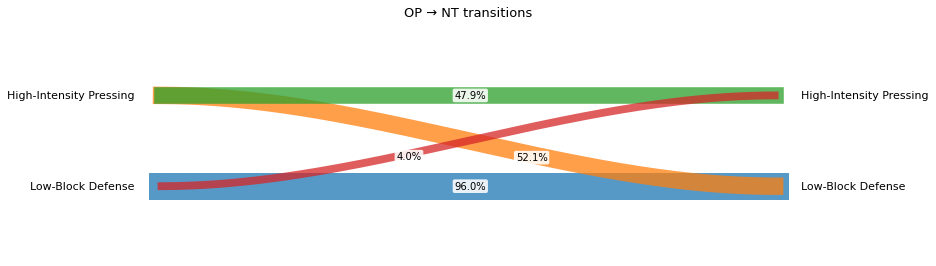

In [11]:
fig_op_nt = static_sankey_with_percentages(
    df=op_nt,
    src_col="label_op",
    tgt_col="label_nt",
    src_phase="op",
    tgt_phase="nt",
    cluster_names=CLUSTER_NAMES,
    label_shift=+.18,
    label_min_dist=.5,
    base_lw=7,
    lw_scale=20,
    figsize=(12, 3.8),
    save_path="../figures/sankey_op_nt_static.png"
)


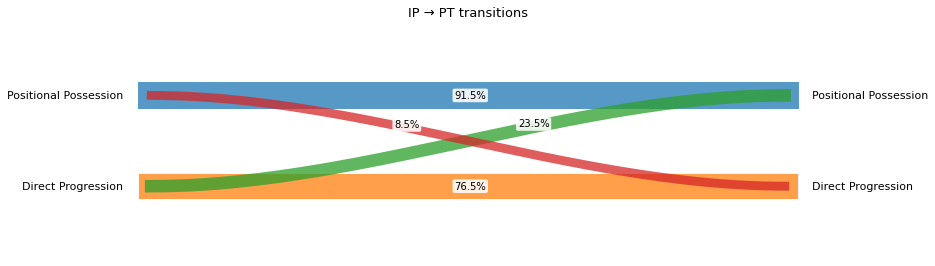

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

def static_sankey_with_percentages(
    df,
    src_col,
    tgt_col,
    src_phase,
    tgt_phase,
    cluster_names,
    normalize="source",          # "source" (row-normalized) or "total"
    title=None,
    figsize=(11, 3.8),
    save_path=None,
    # --- styling knobs ---
    base_lw=6.0,                 # thicker baseline
    lw_scale=18.0,               # thicker scaling by frequency
    label_box_alpha=0.88,
    label_fontsize=10,
    label_dx=0.08,               # spreads labels left-right to reduce overlap
    label_min_dist=0.18,         # collision threshold in axis units (y-scale)
    label_shift=0.16             # vertical shift applied when collision detected
):
    """
    Fully static Sankey-like diagram using Matplotlib with ALWAYS-visible percentages.

    Fixes:
    - Rows are aligned by cluster *name* (not integer label)
    - Pipes are thicker
    - Percentage labels are shifted to avoid overlap
    """

    # --- map labels -> names for each phase ---
    src_label_to_name = cluster_names[src_phase].copy()
    tgt_label_to_name = cluster_names[tgt_phase].copy()

    # ensure ints
    src_vals = df[src_col].astype(int).tolist()
    tgt_vals = df[tgt_col].astype(int).tolist()

    # --- flows counts ---
    flows = Counter(zip(src_vals, tgt_vals))

    # --- denominators for percentages ---
    if normalize == "source":
        src_totals = Counter(src_vals)
        pct = {
            (s, t): (v / src_totals[s] * 100 if src_totals[s] > 0 else 0.0)
            for (s, t), v in flows.items()
        }
    elif normalize == "total":
        total = sum(flows.values()) if flows else 1
        pct = {(s, t): (v / total * 100) for (s, t), v in flows.items()}
    else:
        raise ValueError("normalize must be 'source' or 'total'")

    # --- NAME-BASED ROW ALIGNMENT ---
    # canonical row order = unique names across both phases (preserve a sensible order)
    src_names = [src_label_to_name[l] for l in sorted(src_label_to_name.keys())]
    tgt_names = [tgt_label_to_name[l] for l in sorted(tgt_label_to_name.keys())]

    # Build canonical order: keep src order first, then append unseen target names
    canonical_names = []
    for n in src_names + tgt_names:
        if n not in canonical_names:
            canonical_names.append(n)

    name_to_y = {name: i for i, name in enumerate(canonical_names)}

    # y positions per label (by name)
    y_src = {lab: name_to_y[src_label_to_name[lab]] for lab in src_label_to_name.keys()}
    y_tgt = {lab: name_to_y[tgt_label_to_name[lab]] for lab in tgt_label_to_name.keys()}

    # --- plot setup ---
    fig, ax = plt.subplots(figsize=figsize)
    ax.axis("off")

    x0, x1 = 0.10, 0.90

    # draw node labels (left/right) by canonical name positions
    # left side: only names that appear in src
    for lab, nm in src_label_to_name.items():
        ax.text(
            x0 - 0.035, name_to_y[nm],
            nm, ha="right", va="center", fontsize=11
        )

    # right side: only names that appear in tgt
    for lab, nm in tgt_label_to_name.items():
        ax.text(
            x1 + 0.035, name_to_y[nm],
            nm, ha="left", va="center", fontsize=11
        )

    # helper to draw smooth curve and return a "label point"
    def draw_curve(x0, y0, x1, y1, lw):
        xs = np.linspace(x0, x1, 140)
        tt = np.linspace(0, 1, 140)
        smooth = tt * tt * (3 - 2 * tt)          # smoothstep
        ys = y0 + (y1 - y0) * smooth
        ax.plot(xs, ys, linewidth=lw, alpha=0.75)

        # label point near the middle
        mid = len(xs) // 2
        return xs[mid], ys[mid], xs, ys

    # to avoid label collisions
    placed = []

    # order flows by thickness so big ones get clean label placement first
    max_flow = max(flows.values()) if flows else 1

    # precompute indices for label spreading
    # use canonical name y positions to define "direction" buckets
    def name_index_for_src(s): return name_to_y[src_label_to_name[s]]
    def name_index_for_tgt(t): return name_to_y[tgt_label_to_name[t]]

    for (s, t), v in sorted(flows.items(), key=lambda kv: (-kv[1], kv[0][0], kv[0][1])):
        lw = base_lw + lw_scale * (v / max_flow)

        xm, ym, xs, ys = draw_curve(x0, y_src[s], x1, y_tgt[t], lw)

        # Spread labels in X based on relative target position (reduces overlaps)
        # (works especially when curves cross)
        delta = (name_index_for_src(s) - name_index_for_tgt(t))
        xm = xm + np.clip(delta, -1, 1) * label_dx


        # Collision avoidance: if too close to existing labels, shift up/down
        shift_dir = 1
        attempts = 0
        while any(abs(ym - py) < label_min_dist and abs(xm - px) < 0.10 for (px, py) in placed):
            ym = ym + shift_dir * label_shift
            shift_dir *= -1
            attempts += 1
            if attempts > 6:
                break

        placed.append((xm, ym))

        txt = f"{pct[(s, t)]:.1f}%"

        ax.text(
            xm, ym, txt,
            ha="center", va="center",
            fontsize=label_fontsize,
            bbox=dict(boxstyle="round,pad=0.18", fc="white", ec="none", alpha=label_box_alpha)
        )

    if title is None:
        norm_txt = "row-normalized" if normalize == "source" else "overall-normalized"
        title = f"{src_phase.upper()} → {tgt_phase.upper()} transitions"

    ax.set_title(title, fontsize=13)

    # expand y-limits a bit so shifted labels don't get cut off
    ymin = -0.8
    ymax = len(canonical_names) - 0.2
    ax.set_ylim(ymax, ymin)  # invert so first row is on top

    plt.tight_layout()
    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches="tight")
    return fig


fig_ip_pt = static_sankey_with_percentages(
    df=ip_pt,
    src_col="label_ip",
    tgt_col="label_pt",
    src_phase="ip",
    tgt_phase="pt",
    cluster_names=CLUSTER_NAMES,
    label_shift=-0.18,
    label_min_dist=0.5,
    base_lw=7,
    lw_scale=20,
    figsize=(12, 3.8),
    save_path="../figures/sankey_ip_pt_static.png"
)


In [13]:
# ==========================================================
# STATIC SANKEY EXPORT FOR PAPER
# ==========================================================

import plotly.io as pio

fig_ip_pt = sankey_two_phase(
    ip_pt,
    "label_ip",
    "label_pt",
    src_phase="ip",
    tgt_phase="pt"
)

fig_op_nt = sankey_two_phase(
    op_nt,
    "label_op",
    "label_nt",
    src_phase="op",
    tgt_phase="nt"
)

# Remove hover (important for paper)
fig_ip_pt.update_traces(hoverinfo="none")
fig_op_nt.update_traces(hoverinfo="none")

# Improve layout for print
for fig in [fig_ip_pt, fig_op_nt]:
    fig.update_layout(
        font_size=12,
        width=900,
        height=500,
        margin=dict(l=20, r=20, t=40, b=20)
    )


NameError: name 'sankey_two_phase' is not defined

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

def static_sankey_two_phase(
    df,
    src_col,
    tgt_col,
    src_labels,
    tgt_labels,
    title
):
    """
    Static Sankey-style plot using Matplotlib.
    - df: dataframe containing src_col and tgt_col
    - src_col: source cluster column
    - tgt_col: target cluster column
    - src_labels: dict {label:int -> name:str}
    - tgt_labels: dict {label:int -> name:str}
    """

    flows = Counter(zip(df[src_col], df[tgt_col]))

    fig, ax = plt.subplots(figsize=(7, 4))
    ax.axis("off")

    # Vertical positions
    left_y = {k: i for i, k in enumerate(src_labels.keys())}
    right_y = {k: i for i, k in enumerate(tgt_labels.keys())}

    # Draw flow lines
    for (s, t), v in flows.items():
        ax.plot(
            [0, 1],
            [left_y[s], right_y[t]],
            linewidth=0.8 + v / 6,   # thickness reflects frequency
            alpha=0.7,
            color="steelblue"
        )

    # Source labels (left)
    for k, y in left_y.items():
        ax.text(
            -0.05, y,
            src_labels[k],
            ha="right",
            va="center",
            fontsize=11
        )

    # Target labels (right)
    for k, y in right_y.items():
        ax.text(
            1.05, y,
            tgt_labels[k],
            ha="left",
            va="center",
            fontsize=11
        )

    ax.set_title(title, fontsize=13)
    plt.tight_layout()
    return fig


In [ ]:
# ==========================================================
# C) WIN % TABLES (PER PHASE)
# ==========================================================
for phase in ["ip", "pt", "op", "nt"]:
    m, pct, matrix = analyze_phase_success(phase)

    # attach readable names inside match-level df too
    m_named = add_named_cluster_columns(m, phase)

    print(f"\n===== {phase.upper()} cluster success (Win/Draw/Lose %) [NAMED] =====")
    display(win_percentages_named(pct, phase))

    win_grid = win_grid_named(matrix, phase)
    if win_grid is not None:
        print(f"\n===== {phase.upper()} Win% grid: Cluster vs Opponent Cluster [NAMED] =====")
        display(win_grid)

In [14]:
# ==========================================================
# D) CONSISTENCY vs TRANSITION CHANGE (TEAM LISTS)
# ==========================================================
res = consistency_and_transition_change(ip_pt, op_nt)

print("\n===== Teams CONSISTENT between IP and PT =====")
display(res["consistent_ip_pt"])

print("\n===== Teams that CHANGE style in Transition (IP → PT) =====")
display(res["change_ip_pt"])

print("\n===== Teams CONSISTENT between OP and NT =====")
display(res["consistent_op_nt"])

print("\n===== Teams that CHANGE style in Transition (OP → NT) =====")
display(res["change_op_nt"])


===== Teams CONSISTENT between IP and PT =====


,teamId,name,ip_name,pt_name
92,3789,Amiens SC,Direct Progression,Direct Progression
94,3799,Angers,Direct Progression,Direct Progression
54,2481,Augsburg,Direct Progression,Direct Progression
65,3166,Bologna,Direct Progression,Direct Progression
36,1651,Brighton & Hove Albion,Direct Progression,Direct Progression
...,...,...,...,...
6,680,Sevilla,Positional Possession,Positional Possession
27,1624,Tottenham Hotspur,Positional Possession,Positional Possession
0,674,Valencia,Positional Possession,Positional Possession
7,682,Villarreal,Positional Possession,Positional Possession



===== Teams that CHANGE style in Transition (IP → PT) =====


,teamId,name,ip_name,pt_name
4,678,Athletic Club,Direct Progression,Positional Possession
89,3783,Caen,Direct Progression,Positional Possession
3,677,Deportivo La Coru\u00f1a,Direct Progression,Positional Possession
52,2462,Eintracht Frankfurt,Direct Progression,Positional Possession
11,691,Espanyol,Direct Progression,Positional Possession
71,3193,Genoa,Direct Progression,Positional Possession
50,2457,Hertha BSC,Direct Progression,Positional Possession
53,2463,K\u00f6ln,Direct Progression,Positional Possession
85,3777,Metz,Direct Progression,Positional Possession
25,1619,Southampton,Direct Progression,Positional Possession



===== Teams CONSISTENT between OP and NT =====


,teamId,name,op_name,nt_name
42,2446,Bayer Leverkusen,High-Intensity Pressing,High-Intensity Pressing
75,3219,Benevento,High-Intensity Pressing,High-Intensity Pressing
81,3772,Bordeaux,High-Intensity Pressing,High-Intensity Pressing
12,692,Celta de Vigo,High-Intensity Pressing,High-Intensity Pressing
21,1610,Chelsea,High-Intensity Pressing,High-Intensity Pressing
...,...,...,...,...
93,3795,Troyes,Low-Block Defense,Low-Block Defense
39,2443,Werder Bremen,Low-Block Defense,Low-Block Defense
29,1627,West Bromwich Albion,Low-Block Defense,Low-Block Defense
32,1633,West Ham United,Low-Block Defense,Low-Block Defense



===== Teams that CHANGE style in Transition (OP → NT) =====


,teamId,name,op_name,nt_name
37,1659,AFC Bournemouth,High-Intensity Pressing,Low-Block Defense
92,3789,Amiens SC,High-Intensity Pressing,Low-Block Defense
66,3172,Atalanta,High-Intensity Pressing,Low-Block Defense
5,679,Atl\u00e9tico Madrid,High-Intensity Pressing,Low-Block Defense
43,2447,Borussia Dortmund,High-Intensity Pressing,Low-Block Defense
67,3173,Cagliari,High-Intensity Pressing,Low-Block Defense
95,3804,Dijon,High-Intensity Pressing,Low-Block Defense
71,3193,Genoa,High-Intensity Pressing,Low-Block Defense
15,698,Getafe,High-Intensity Pressing,Low-Block Defense
45,2450,Hamburger SV,High-Intensity Pressing,Low-Block Defense


In [15]:
# ==========================================================
# E1) BUILD FULL 16-CELL ARCHETYPE GRID
# ==========================================================

def build_full_archetype_grid(ip_pt: pd.DataFrame, op_nt: pd.DataFrame):
    """
    Builds all 16 combinations:
      attack ∈ {PP, PD, DP, DD}
      defense ∈ {HH, HL, LH, LL}

    Returns one row per team with:
      teamId, team name, attack_pattern, defense_pattern
    """
    df = ip_pt.merge(
        op_nt,
        on="teamId",
        suffixes=("_attack", "_defense")
    )

    # attack pattern: IP → PT
    df["attack_pattern"] = (
        df["label_ip"].map({0: "P", 1: "D"}) + "-" +
        df["label_pt"].map({0: "P", 1: "D"})
    )

    # defense pattern: OP → NT
    df["defense_pattern"] = (
        df["label_op"].map({0: "H", 1: "L"}) + "-" +
        df["label_nt"].map({1: "H", 0: "L"})
    )

    df = df.merge(teams_df, on="teamId", how="left")

    return df


In [16]:
op_nt

,teamId,label_op,label_nt,op_name,nt_name
0,674,0,1,High-Intensity Pressing,High-Intensity Pressing
1,675,0,1,High-Intensity Pressing,High-Intensity Pressing
2,676,1,1,Low-Block Defense,High-Intensity Pressing
3,677,1,0,Low-Block Defense,Low-Block Defense
4,678,1,0,Low-Block Defense,Low-Block Defense
...,...,...,...,...,...
93,3795,1,0,Low-Block Defense,Low-Block Defense
94,3799,1,0,Low-Block Defense,Low-Block Defense
95,3804,0,0,High-Intensity Pressing,Low-Block Defense
96,10531,1,0,Low-Block Defense,Low-Block Defense


In [17]:
# ==========================================================
# E2) COUNT TEAMS IN EACH ARCHETYPE CELL
# ==========================================================

df_archetypes = build_full_archetype_grid(ip_pt, op_nt)

archetype_counts = (
    df_archetypes
    .groupby(["attack_pattern", "defense_pattern"])
    .size()
    .unstack(fill_value=0)
    .reindex(
        index=["P-P", "P-D", "D-P", "D-D"],
        columns=["H-H", "H-L", "L-H", "L-L"],
        fill_value=0
    )
)

print("\n===== TEAM COUNTS PER (ATTACK × DEFENSE) ARCHETYPE =====")
display(archetype_counts)



===== TEAM COUNTS PER (ATTACK × DEFENSE) ARCHETYPE =====


defense_pattern,H-H,H-L,L-H,L-L
attack_pattern,,,,
P-P,16,12,2,13
P-D,1,1,0,2
D-P,1,2,0,9
D-D,5,10,0,24


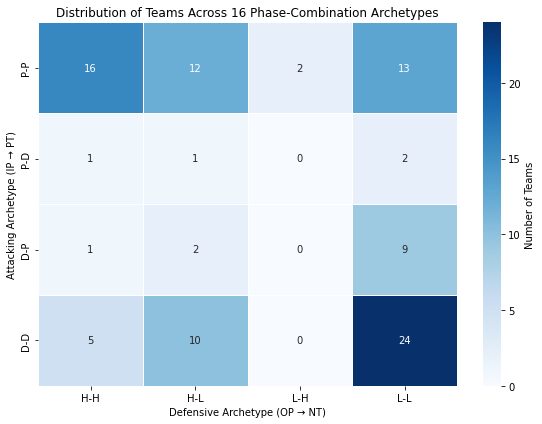

In [18]:
# ==========================================================
# E3) 4×4 HEATMAP OF ARCHETYPE COUNTS
# ==========================================================

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))

sns.heatmap(
    archetype_counts,
    annot=True,
    fmt="d",
    cmap="Blues",
    linewidths=0.5,
    cbar_kws={"label": "Number of Teams"}
)

plt.xlabel("Defensive Archetype (OP → NT)")
plt.ylabel("Attacking Archetype (IP → PT)")
plt.title("Distribution of Teams Across 16 Phase-Combination Archetypes")

plt.tight_layout()
plt.show()


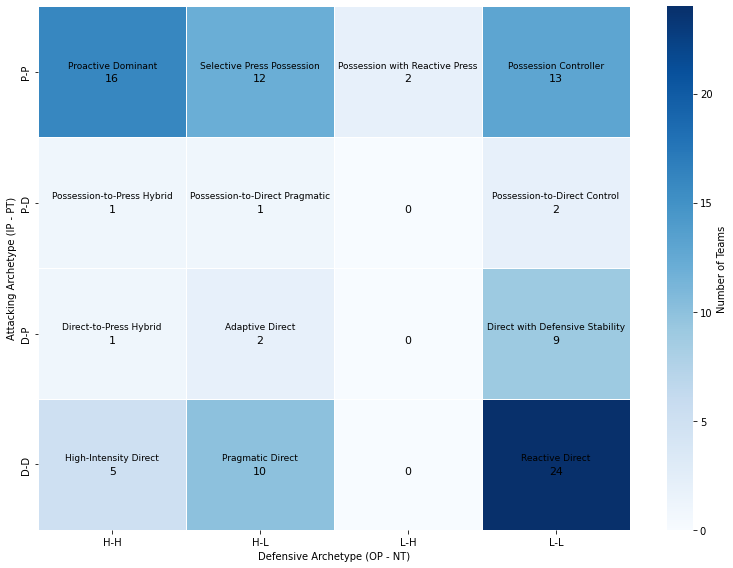

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

ARCHETYPE_NAMES = {
    ("D-D", "L-L"): "Reactive Direct",
    ("P-P", "H-H"): "Proactive Dominant",
    ("P-P", "L-L"): "Possession Controller",
    ("P-P", "H-L"): "Selective Press Possession",
    ("D-D", "H-L"): "Pragmatic Direct",
    ("D-P", "L-L"): "Direct with Defensive Stability",
    ("D-D", "H-H"): "High-Intensity Direct",
    ("P-P", "L-H"): "Possession with Reactive Press",
    ("P-D", "L-L"): "Possession-to-Direct Control",
    ("D-P", "H-L"): "Adaptive Direct",
    ("P-D", "H-H"): "Possession-to-Press Hybrid",
    ("P-D", "H-L"): "Possession-to-Direct Pragmatic",
    ("D-P", "H-H"): "Direct-to-Press Hybrid",
}


plt.figure(figsize=(11, 8))
ax = sns.heatmap(
    archetype_counts,
    cmap="Blues",
    linewidths=0.5,
    cbar_kws={"label": "Number of Teams"}
)

# Add custom annotations
for i, atk in enumerate(archetype_counts.index):
    for j, dfn in enumerate(archetype_counts.columns):
        count = archetype_counts.loc[atk, dfn]
        name = ARCHETYPE_NAMES.get((atk, dfn), "")

        # Archetype name (smaller, upper)
        if name:
            ax.text(
                j + 0.5, i + 0.45,
                name,
                ha="center", va="center",
                fontsize=9,
                color="black"
            )

        # Count (bigger, lower)
        ax.text(
            j + 0.5, i + 0.55,
            str(count),
            ha="center", va="center",
            fontsize=11,      # 🔴 bigger count,
            color="black"
        )

plt.xlabel("Defensive Archetype (OP - NT)")
plt.ylabel("Attacking Archetype (IP - PT)")
#plt.title("Distribution of Teams Across 16 Phase-Combination Archetypes")

plt.tight_layout()
plt.show()


In [ ]:
# ==========================================================
# E4) LIST NON-EMPTY ARCHETYPES (TO BE NAMED)
# ==========================================================

non_empty = (
    archetype_counts
    .stack()
    .reset_index()
    .rename(columns={0: "n_teams"})
)

non_empty = non_empty[non_empty["n_teams"] > 0] \
    .sort_values("n_teams", ascending=False) \
    .reset_index(drop=True)

print("\n===== NON-EMPTY ARCHETYPES (ONLY THESE SHOULD BE NAMED) =====")
display(non_empty)


## By combining attacking (in-possession and positive transition) and defensive (out-of-possession and negative transition) phase styles, we identify up to 16 theoretical phase-combination archetypes. In practice, only 13 archetypes were observed in the data. These archetypes capture holistic team identities ranging from proactive, possession-dominant models with aggressive pressing to reactive, direct approaches with deep defensive structures.

Teams with labeled archetypes: 98


,teamId,name,attack_pattern,defense_pattern,archetype_name
0,674,Valencia,P-P,H-H,Proactive Dominant
1,675,Real Madrid,P-P,H-H,Proactive Dominant
2,676,Barcelona,P-P,L-H,Possession with Reactive Press
3,677,Deportivo La Coru\u00f1a,D-P,L-L,Direct with Defensive Stability
4,678,Athletic Club,D-P,L-L,Direct with Defensive Stability
5,679,Atl\u00e9tico Madrid,P-P,H-L,Selective Press Possession
6,680,Sevilla,P-P,H-L,Selective Press Possession
7,682,Villarreal,P-P,H-H,Proactive Dominant
8,683,M\u00e1laga,D-D,L-L,Reactive Direct
9,684,Real Betis,P-P,L-L,Possession Controller


In [26]:
df_archetypes = df_archetypes.copy()

df_archetypes["archetype_name"] = df_archetypes.apply(
    lambda r: ARCHETYPE_NAMES.get((r["attack_pattern"], r["defense_pattern"]), "Unlabeled"),
    axis=1
)

# Only keep the ones that exist (optional)
df_archetypes_named = df_archetypes[df_archetypes["archetype_name"] != "Unlabeled"].copy()

print("Teams with labeled archetypes:", df_archetypes_named["teamId"].nunique())
display(df_archetypes_named[["teamId","name","attack_pattern","defense_pattern","archetype_name"]].head(10))


Teams with labeled archetypes: 98


,teamId,name,attack_pattern,defense_pattern,archetype_name
0,674,Valencia,P-P,H-H,Proactive Dominant
1,675,Real Madrid,P-P,H-H,Proactive Dominant
2,676,Barcelona,P-P,L-H,Possession with Reactive Press
3,677,Deportivo La Coru\u00f1a,D-P,L-L,Direct with Defensive Stability
4,678,Athletic Club,D-P,L-L,Direct with Defensive Stability
5,679,Atl\u00e9tico Madrid,P-P,H-L,Selective Press Possession
6,680,Sevilla,P-P,H-L,Selective Press Possession
7,682,Villarreal,P-P,H-H,Proactive Dominant
8,683,M\u00e1laga,D-D,L-L,Reactive Direct
9,684,Real Betis,P-P,L-L,Possession Controller


In [27]:
def archetype_win_percentages(df_team_archetypes: pd.DataFrame):
    """
    df_team_archetypes must have: teamId, archetype_name
    Returns: counts + Win/Draw/Lose % per archetype
    """
    # team -> archetype
    team_to_arch = dict(zip(df_team_archetypes["teamId"], df_team_archetypes["archetype_name"]))

    # Use team-match file (IP) only as a "roster" of (teamId, matchId) rows
    # It doesn't matter that it's IP labels; we only need matchId and teamId.
    tm = pd.read_csv(TEAM_MATCH_LABEL_PATHS["ip"])[["matchId", "teamId"]].drop_duplicates()
    tm["teamId"] = tm["teamId"].astype(int)
    tm["matchId"] = tm["matchId"].astype(int)

    tm["archetype_name"] = tm["teamId"].map(team_to_arch)
    tm = tm.dropna(subset=["archetype_name"]).copy()

    # Join match results
    m = tm.merge(
        all_matches_df[["wyId", "winner"]],
        left_on="matchId",
        right_on="wyId",
        how="inner"
    ).drop(columns=["wyId"])

    # W/D/L from your helper
    m = compute_match_result(m)

    # counts table
    counts = (
        m.groupby(["archetype_name", "Match_Result"])
         .size()
         .unstack(fill_value=0)
    )

    # ensure all columns exist
    for col in ["Win", "Draw", "Lose"]:
        if col not in counts.columns:
            counts[col] = 0

    counts["n_matches"] = counts[["Win","Draw","Lose"]].sum(axis=1)

    # percentages
    pct = counts[["Win","Draw","Lose"]].div(counts["n_matches"], axis=0) * 100

    out = pd.concat([counts[["n_matches"]], pct], axis=1).reset_index()
    out = out.sort_values(["Win", "n_matches"], ascending=[False, False]).reset_index(drop=True)

    return out


archetype_perf = archetype_win_percentages(df_archetypes_named)

print("\n===== ARCHETYPE PERFORMANCE (Win/Draw/Lose %) =====")
display(archetype_perf)



===== ARCHETYPE PERFORMANCE (Win/Draw/Lose %) =====


Match_Result,archetype_name,n_matches,Win,Draw,Lose
0,Possession with Reactive Press,76,63.157895,27.631579,9.210526
1,Proactive Dominant,596,55.704698,22.315436,21.979866
2,Possession Controller,478,47.280335,23.012552,29.707113
3,Selective Press Possession,452,45.132743,23.008850,31.858407
4,Possession-to-Direct Pragmatic,38,34.210526,39.473684,26.315789
5,Direct-to-Press Hybrid,38,31.578947,10.526316,57.894737
6,Possession-to-Direct Control,76,30.263158,23.684211,46.052632
7,Pragmatic Direct,372,28.494624,28.494624,43.010753
8,Reactive Direct,896,28.348214,26.339286,45.312500
9,Adaptive Direct,76,27.631579,22.368421,50.000000


In [28]:
def teams_per_archetype(df_team_archetypes: pd.DataFrame):
    out = (
        df_team_archetypes.groupby("archetype_name")["name"]
        .apply(lambda s: sorted([x for x in s.dropna().unique().tolist()]))
        .reset_index()
        .rename(columns={"name": "teams"})
    )
    out["n_teams"] = out["teams"].apply(len)
    out = out.sort_values("n_teams", ascending=False).reset_index(drop=True)
    return out


teams_by_arch = teams_per_archetype(df_archetypes_named)

print("\n===== TEAMS PER ARCHETYPE =====")
display(teams_by_arch)

# Pretty print
for _, row in teams_by_arch.iterrows():
    print(f"\n--- {row['archetype_name']} ({row['n_teams']} teams) ---")
    print(", ".join(row["teams"]))



===== TEAMS PER ARCHETYPE =====


,archetype_name,teams,n_teams
0,Reactive Direct,"[Angers, Augsburg, Bologna, Brighton & Hove Al...",24
1,Proactive Dominant,"[Bayer Leverkusen, Bordeaux, Celta de Vigo, Ch...",16
2,Possession Controller,"[Arsenal, Bayern M\u00fcnchen, Borussia M'glad...",13
3,Selective Press Possession,"[AFC Bournemouth, Atalanta, Atl\u00e9tico Madr...",12
4,Pragmatic Direct,"[Amiens SC, Cagliari, Dijon, Getafe, Hamburger...",10
5,Direct with Defensive Stability,"[Athletic Club, Caen, Deportivo La Coru\u00f1a...",9
6,High-Intensity Direct,"[Crystal Palace, Hellas Verona, Mainz 05, Sass...",5
7,Adaptive Direct,"[Genoa, Watford]",2
8,Possession with Reactive Press,"[Barcelona, Internazionale]",2
9,Possession-to-Direct Control,"[Nice, Swansea City]",2



--- Reactive Direct (24 teams) ---
Angers, Augsburg, Bologna, Brighton & Hove Albion, Burnley, Chievo, Crotone, Deportivo Alav\u00e9s, Eibar, Everton, Freiburg, Girona, Legan\u00e9s, Levante, M\u00e1laga, Nantes, Newcastle United, Stoke City, Stuttgart, Toulouse, Troyes, Werder Bremen, West Bromwich Albion, West Ham United

--- Proactive Dominant (16 teams) ---
Bayer Leverkusen, Bordeaux, Celta de Vigo, Chelsea, Lazio, Liverpool, Manchester City, Monaco, Olympique Lyonnais, PSG, RB Leipzig, Real Madrid, Roma, Schalke 04, Valencia, Villarreal

--- Possession Controller (13 teams) ---
Arsenal, Bayern M\u00fcnchen, Borussia M'gladbach, Fiorentina, Guingamp, Hoffenheim, Milan, Napoli, Real Betis, Saint-\u00c9tienne, Sampdoria, Tottenham Hotspur, Wolfsburg

--- Selective Press Possession (12 teams) ---
AFC Bournemouth, Atalanta, Atl\u00e9tico Madrid, Borussia Dortmund, Juventus, Las Palmas, Lille, Manchester United, Olympique Marseille, Real Sociedad, Rennes, Sevilla

--- Pragmatic Direct 

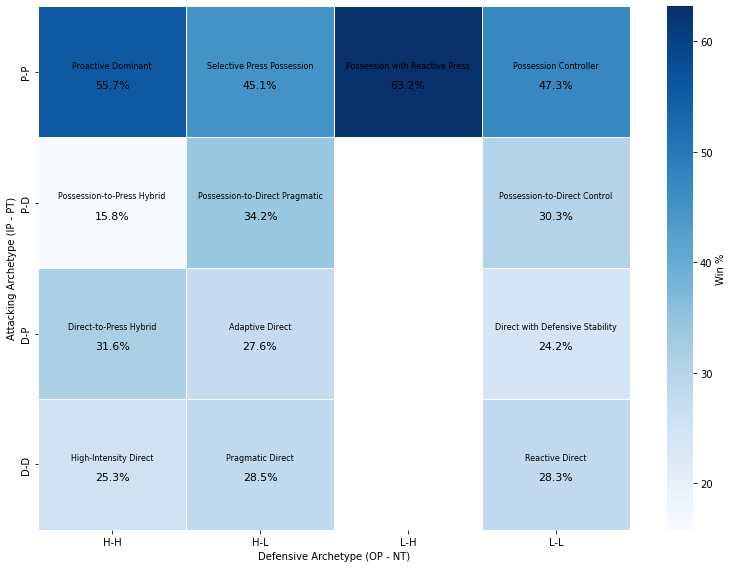

In [29]:
def archetype_win_heatmap(df_team_archetypes: pd.DataFrame):
    team_to_arch = dict(zip(df_team_archetypes["teamId"], df_team_archetypes["archetype_name"]))

    tm = pd.read_csv(TEAM_MATCH_LABEL_PATHS["ip"])[["matchId", "teamId"]].drop_duplicates()
    tm["teamId"] = tm["teamId"].astype(int)
    tm["matchId"] = tm["matchId"].astype(int)

    # attach patterns too (so we can place into grid)
    team_to_attack = dict(zip(df_team_archetypes["teamId"], df_team_archetypes["attack_pattern"]))
    team_to_def = dict(zip(df_team_archetypes["teamId"], df_team_archetypes["defense_pattern"]))

    tm["attack_pattern"] = tm["teamId"].map(team_to_attack)
    tm["defense_pattern"] = tm["teamId"].map(team_to_def)
    tm["archetype_name"] = tm["teamId"].map(team_to_arch)

    tm = tm.dropna(subset=["archetype_name","attack_pattern","defense_pattern"]).copy()

    m = tm.merge(
        all_matches_df[["wyId", "winner"]],
        left_on="matchId",
        right_on="wyId",
        how="inner"
    ).drop(columns=["wyId"])

    m = compute_match_result(m)

    # compute win% per cell
    cell_counts = (
        m.groupby(["attack_pattern","defense_pattern","Match_Result"])
         .size()
         .unstack(fill_value=0)
         .reset_index()
    )

    # ensure columns
    for col in ["Win","Draw","Lose"]:
        if col not in cell_counts.columns:
            cell_counts[col] = 0

    cell_counts["n_matches"] = cell_counts[["Win","Draw","Lose"]].sum(axis=1)
    cell_counts["win_pct"] = np.where(cell_counts["n_matches"]>0, cell_counts["Win"]/cell_counts["n_matches"]*100, np.nan)

    win_grid = (
        cell_counts.pivot(index="attack_pattern", columns="defense_pattern", values="win_pct")
        .reindex(index=["P-P","P-D","D-P","D-D"], columns=["H-H","H-L","L-H","L-L"])
    )

    return win_grid


win_grid = archetype_win_heatmap(df_archetypes_named)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(11, 8))
ax = sns.heatmap(
    win_grid,
    cmap="Blues",
    linewidths=0.5,
    cbar_kws={"label": "Win %"}
)

# Manual annotations
for i, atk in enumerate(win_grid.index):
    for j, dfn in enumerate(win_grid.columns):
        win_pct = win_grid.loc[atk, dfn]
        name = ARCHETYPE_NAMES.get((atk, dfn), "")

        if np.isnan(win_pct):
            continue

        # Archetype name (smaller, upper)
        if name:
            ax.text(
                j + 0.5, i + 0.45,
                name,
                ha="center", va="center",
                fontsize=8,
                color="black"
            )

        # Win percentage (bigger, lower)
        ax.text(
            j + 0.5, i + 0.6,
            f"{win_pct:.1f}%",
            ha="center", va="center",
            fontsize=11,
            color="black"
        )

plt.xlabel("Defensive Archetype (OP - NT)")
plt.ylabel("Attacking Archetype (IP - PT)")
#plt.title("Win Percentages by Holistic Archetypes")

plt.tight_layout()
plt.show()


In [30]:
win_grid

defense_pattern,H-H,H-L,L-H,L-L
attack_pattern,,,,
P-P,55.704698,45.132743,63.157895,47.280335
P-D,15.789474,34.210526,NaN,30.263158
D-P,31.578947,27.631579,NaN,24.242424
D-D,25.268817,28.494624,NaN,28.348214


In [45]:
archetype_perf

Match_Result,archetype_name,n_matches,Win,Draw,Lose
0,Possession with Reactive Press,76,63.157895,27.631579,9.210526
1,Proactive Dominant,596,55.704698,22.315436,21.979866
2,Possession Controller,478,47.280335,23.012552,29.707113
3,Selective Press Possession,452,45.132743,23.008850,31.858407
4,Possession-to-Direct Pragmatic,38,34.210526,39.473684,26.315789
5,Direct-to-Press Hybrid,38,31.578947,10.526316,57.894737
6,Possession-to-Direct Control,76,30.263158,23.684211,46.052632
7,Pragmatic Direct,372,28.494624,28.494624,43.010753
8,Reactive Direct,896,28.348214,26.339286,45.312500
9,Adaptive Direct,76,27.631579,22.368421,50.000000


# Holistic Phase-Combination Archetypes and Match Outcomes

## By combining attacking (in-possession and positive transition) and defensive (out-of-possession and negative transition) styles, we identified 13 empirically observed phase-combination archetypes out of 16 theoretical possibilities. These archetypes represent holistic team identities across all major game phases.

## Results reveal a clear performance hierarchy among archetypes. Possession-oriented attacking styles consistently outperform direct approaches, particularly when combined with structured or selective defensive behaviors. The highest win probability (63.2%) was observed for teams adopting a Possession with Reactive Press archetype, characterized by sustained ball circulation and restrained defensive engagement that intensifies selectively during negative transitions.

## The Proactive Dominant archetype, combining positional possession with persistent high-intensity pressing, also achieved strong performance (55.7%) across a large number of matches (n = 596), indicating robustness but potentially higher physical and tactical demands.

## In contrast, archetypes centered on direct attacking strategies exhibited substantially lower win rates, particularly when combined with inconsistent or hybrid defensive behaviors. Notably, the Reactive Direct archetype, although the most prevalent in the dataset, achieved a win rate of only 28.3%, suggesting its frequent use by less dominant teams.

## Hybrid archetypes involving abrupt cross-phase style shifts performed poorest, providing empirical evidence that cross-phase coherence plays a critical role in overall team success.

In [46]:
# ==========================================================
# LEAGUE-WISE ARCHETYPE PERFORMANCE
# ==========================================================

def league_wise_archetype_performance(df_team_archetypes):
    """
    Returns win % per archetype per league.
    """
    # team → archetype
    team_to_arch = dict(zip(df_team_archetypes["teamId"], df_team_archetypes["archetype_name"]))

    # Build match-level table
    tm = pd.read_csv(TEAM_MATCH_LABEL_PATHS["ip"])[["matchId", "teamId"]].drop_duplicates()
    tm["teamId"] = tm["teamId"].astype(int)
    tm["matchId"] = tm["matchId"].astype(int)
    tm["archetype_name"] = tm["teamId"].map(team_to_arch)
    tm = tm.dropna(subset=["archetype_name"])

    # Attach match + league info
    m = tm.merge(
        all_matches_df[["wyId", "winner", "competitionId"]],
        left_on="matchId",
        right_on="wyId",
        how="inner"
    ).drop(columns=["wyId"])

    m = compute_match_result(m)

    # Win % per league × archetype
    counts = (
        m.groupby(["competitionId", "archetype_name", "Match_Result"])
         .size()
         .unstack(fill_value=0)
         .reset_index()
    )

    counts["n_matches"] = counts[["Win","Draw","Lose"]].sum(axis=1)
    counts["win_pct"] = counts["Win"] / counts["n_matches"] * 100

    return counts


league_perf = league_wise_archetype_performance(df_archetypes_named)


In [47]:
print("\n===== TOP-2 ARCHETYPES PER LEAGUE =====")

for league_id, g in league_perf.groupby("competitionId"):
    top2 = (
        g.sort_values("win_pct", ascending=False)
         .head(2)[["archetype_name","win_pct","n_matches"]]
    )

    print(f"\nLeague {league_id}")
    display(top2)



===== TOP-2 ARCHETYPES PER LEAGUE =====

League 364


Match_Result,archetype_name,win_pct,n_matches
6,Proactive Dominant,64.912281,114
3,Possession Controller,55.263158,76



League 412


Match_Result,archetype_name,win_pct,n_matches
14,Proactive Dominant,60.526316,152
16,Selective Press Possession,42.105263,114



League 426


Match_Result,archetype_name,win_pct,n_matches
21,Proactive Dominant,46.078431,102
19,Possession Controller,44.852941,136



League 524


Match_Result,archetype_name,win_pct,n_matches
34,Selective Press Possession,60.526316,76
32,Proactive Dominant,57.894737,76



League 795


Match_Result,archetype_name,win_pct,n_matches
37,Possession with Reactive Press,73.684211,38
39,Proactive Dominant,49.342105,152


In [48]:
# ==========================================================
# LEAGUE × ARCHETYPE × TEAM NAMES
# ==========================================================

def league_archetype_teams(df_team_archetypes):
    """
    Returns a table:
      competitionId | archetype_name | n_teams | teams
    """

    # team → archetype
    team_to_arch = dict(zip(
        df_team_archetypes["teamId"],
        df_team_archetypes["archetype_name"]
    ))

    # team → name
    team_to_name = dict(zip(
        df_team_archetypes["teamId"],
        df_team_archetypes["name"]
    ))

    # Build (teamId, matchId) base
    tm = pd.read_csv(TEAM_MATCH_LABEL_PATHS["ip"])[["matchId", "teamId"]].drop_duplicates()
    tm["teamId"] = tm["teamId"].astype(int)
    tm["matchId"] = tm["matchId"].astype(int)

    tm["archetype_name"] = tm["teamId"].map(team_to_arch)
    tm["team_name"] = tm["teamId"].map(team_to_name)

    tm = tm.dropna(subset=["archetype_name", "team_name"])

    # Attach league info
    tm = tm.merge(
        all_matches_df[["wyId", "competitionId"]],
        left_on="matchId",
        right_on="wyId",
        how="inner"
    ).drop(columns=["wyId"])

    # Aggregate unique teams per league × archetype
    out = (
        tm.groupby(["competitionId", "archetype_name"])["team_name"]
        .apply(lambda x: sorted(x.unique().tolist()))
        .reset_index()
        .rename(columns={"team_name": "teams"})
    )

    out["n_teams"] = out["teams"].apply(len)

    return out.sort_values(["competitionId", "n_teams"], ascending=[True, False])


In [49]:
league_archetype_team_table = league_archetype_teams(df_archetypes_named)

print("\n===== LEAGUE × ARCHETYPE × TEAM NAMES =====")
display(league_archetype_team_table)



===== LEAGUE × ARCHETYPE × TEAM NAMES =====


,competitionId,archetype_name,teams,n_teams
7,364,Reactive Direct,"[Brighton & Hove Albion, Burnley, Everton, New...",7
6,364,Proactive Dominant,"[Chelsea, Liverpool, Manchester City]",3
3,364,Possession Controller,"[Arsenal, Tottenham Hotspur]",2
5,364,Pragmatic Direct,"[Huddersfield Town, Leicester City]",2
8,364,Selective Press Possession,"[AFC Bournemouth, Manchester United]",2
0,364,Adaptive Direct,[Watford],1
1,364,Direct with Defensive Stability,[Southampton],1
2,364,High-Intensity Direct,[Crystal Palace],1
4,364,Possession-to-Direct Control,[Swansea City],1
14,412,Proactive Dominant,"[Bordeaux, Monaco, Olympique Lyonnais, PSG]",4


In [50]:
def print_league_archetype_examples(df, league_id):
    print(f"\n===== LEAGUE {league_id}: ARCHETYPES & TEAMS =====")
    g = df[df["competitionId"] == league_id]

    for _, row in g.iterrows():
        print(f"\n{row['archetype_name']} ({row['n_teams']} teams)")
        print(", ".join(row["teams"]))
for league_id in league_archetype_team_table["competitionId"].unique():
    print_league_archetype_examples(league_archetype_team_table, league_id)


===== LEAGUE 364: ARCHETYPES & TEAMS =====

Reactive Direct (7 teams)
Brighton & Hove Albion, Burnley, Everton, Newcastle United, Stoke City, West Bromwich Albion, West Ham United

Proactive Dominant (3 teams)
Chelsea, Liverpool, Manchester City

Possession Controller (2 teams)
Arsenal, Tottenham Hotspur

Pragmatic Direct (2 teams)
Huddersfield Town, Leicester City

Selective Press Possession (2 teams)
AFC Bournemouth, Manchester United

Adaptive Direct (1 teams)
Watford

Direct with Defensive Stability (1 teams)
Southampton

High-Intensity Direct (1 teams)
Crystal Palace

Possession-to-Direct Control (1 teams)
Swansea City

===== LEAGUE 412: ARCHETYPES & TEAMS =====

Proactive Dominant (4 teams)
Bordeaux, Monaco, Olympique Lyonnais, PSG

Reactive Direct (4 teams)
Angers, Nantes, Toulouse, Troyes

Pragmatic Direct (3 teams)
Amiens SC, Dijon, Montpellier

Selective Press Possession (3 teams)
Lille, Olympique Marseille, Rennes

Direct with Defensive Stability (2 teams)
Caen, Metz

Posse

In [51]:
# ==========================================================
# BOOTSTRAP CONFIDENCE INTERVALS
# ==========================================================

def bootstrap_win_ci(df_team_archetypes, n_boot=1000, random_state=42):
    np.random.seed(random_state)

    team_to_arch = dict(zip(df_team_archetypes["teamId"], df_team_archetypes["archetype_name"]))

    tm = pd.read_csv(TEAM_MATCH_LABEL_PATHS["ip"])[["matchId", "teamId"]].drop_duplicates()
    tm["teamId"] = tm["teamId"].astype(int)
    tm["matchId"] = tm["matchId"].astype(int)
    tm["archetype_name"] = tm["teamId"].map(team_to_arch)
    tm = tm.dropna(subset=["archetype_name"])

    m = tm.merge(
        all_matches_df[["wyId", "winner"]],
        left_on="matchId",
        right_on="wyId",
        how="inner"
    ).drop(columns=["wyId"])

    m = compute_match_result(m)
    m["is_win"] = (m["Match_Result"] == "Win").astype(int)

    results = []

    for arch, g in m.groupby("archetype_name"):
        win_rates = []

        for _ in range(n_boot):
            sample = g.sample(frac=1, replace=True)
            win_rates.append(sample["is_win"].mean() * 100)

        results.append({
            "archetype_name": arch,
            "win_pct_mean": np.mean(win_rates),
            "win_pct_ci_low": np.percentile(win_rates, 2.5),
            "win_pct_ci_high": np.percentile(win_rates, 97.5),
            "n_matches": len(g)
        })

    return pd.DataFrame(results).sort_values("win_pct_mean", ascending=False)


bootstrap_ci = bootstrap_win_ci(df_archetypes_named)

print("\n===== BOOTSTRAPPED WIN% CONFIDENCE INTERVALS =====")
display(bootstrap_ci)



===== BOOTSTRAPPED WIN% CONFIDENCE INTERVALS =====


,archetype_name,win_pct_mean,win_pct_ci_low,win_pct_ci_high,n_matches
5,Possession with Reactive Press,63.303947,51.315789,73.684211,76
10,Proactive Dominant,55.667785,51.505872,59.731544,596
4,Possession Controller,47.244351,43.096234,51.673640,478
12,Selective Press Possession,45.043805,40.486726,50.221239,452
7,Possession-to-Direct Pragmatic,34.278947,21.052632,50.000000,38
2,Direct-to-Press Hybrid,31.565789,18.421053,44.802632,38
6,Possession-to-Direct Control,30.068421,19.736842,40.789474,76
9,Pragmatic Direct,28.461559,24.193548,32.795699,372
11,Reactive Direct,28.306250,25.446429,31.361607,896
0,Adaptive Direct,27.527632,18.421053,38.157895,76


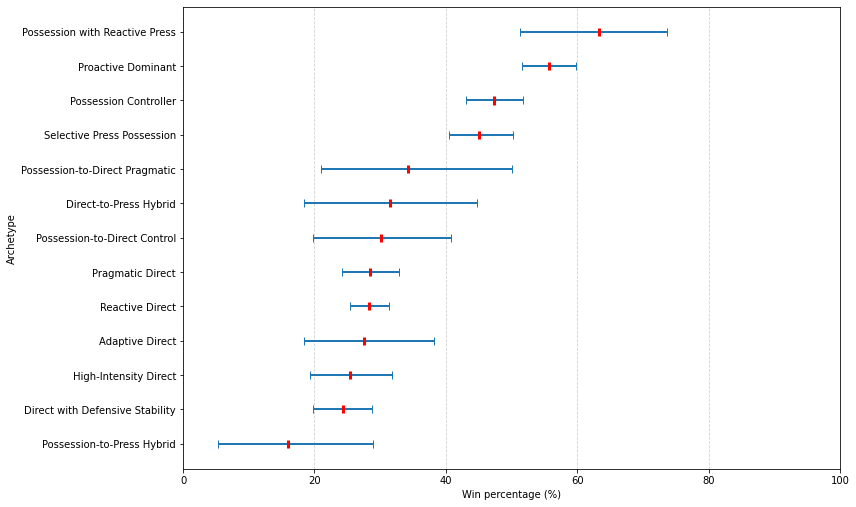

In [60]:
import numpy as np
import matplotlib.pyplot as plt

# Sort best -> worst (top -> bottom)
df = bootstrap_ci.sort_values("win_pct_mean", ascending=False).reset_index(drop=True).copy()

labels = df["archetype_name"].astype(str).tolist()
means  = df["win_pct_mean"].to_numpy()
low    = df["win_pct_ci_low"].to_numpy()
high   = df["win_pct_ci_high"].to_numpy()

y = np.arange(len(df))

# error sizes for matplotlib: [left_errors, right_errors]
xerr = np.vstack([means - low, high - means])

plt.figure(figsize=(12, max(5, 0.55 * len(df))))

# CI intervals
plt.errorbar(
    means, y,
    xerr=xerr,
    fmt="none",         # no marker here; we add mean marker separately
    elinewidth=2,
    capsize=4
)

# Mean as a point (distinct marker)
plt.vlines(means, y - 0.12, y + 0.12, linewidth=3, zorder=3, color = 'red')

# Optional: show sample size next to label (comment out if you don't want it)
# new_labels = [f"{lab} (n={n})" for lab, n in zip(labels, df["n_matches"].tolist())]
# plt.yticks(y, new_labels)
plt.yticks(y, labels)

plt.xlim(0, 100)
plt.xlabel("Win percentage (%)")
plt.ylabel("Archetype")
#plt.title("Win percentage by archetype with 95% bootstrap confidence intervals")

# Put best at top
plt.gca().invert_yaxis()

# Light grid for readability
plt.grid(axis="x", linestyle="--", linewidth=0.8, alpha=0.6)

plt.tight_layout()
plt.show()


#  Bootstrap Confidence Interval Analysis

## To assess the statistical robustness of the observed differences in win probabilities across holistic phase-combination archetypes, uncertainty in archetype-level win probabilities was quantified using non-parametric bootstrap confidence intervals (1,000 resamples) following standard practice in statistical inference [Efron and Tibshirani, 1993]. This process yields an empirical distribution of win rates per archetype, from which 95% confidence intervals were derived using the 2.5th and 97.5th percentiles. Importantly, bootstrapping does not rely on distributional assumptions and is therefore well suited to heterogeneous match samples with unequal archetype frequencies.

## The resulting confidence intervals provide insight into both performance level and uncertainty. Archetypes characterized by possession-oriented attacking behavior exhibit not only higher mean win probabilities but also comparatively narrow confidence intervals, indicating stable and consistent performance across matches. In particular, the Possession with Reactive Press and Proactive Dominant archetypes maintain clearly separated confidence ranges from most direct-oriented archetypes, suggesting that their superior performance is not driven by sampling variability alone. Conversely, hybrid archetypes combining abrupt cross-phase style shifts display wider confidence intervals, reflecting both smaller sample sizes and greater outcome variability. Overall, the bootstrap analysis reinforces the main findings by demonstrating that cross-phase tactical coherence—especially when centered on possession-based attacking identities—is associated with reliably higher match success rather than isolated performance spikes.